#what is this notebook?
In This notebook, we have tried to compare 5 different methods for making the network from the disease-symptom dataset.

#Imports and loading dataset

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
import networkx as nx
import matplotlib.pyplot as plt


In [2]:
# Upload CSV file to the Colab, data is the main dataset.
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
data = pd.read_csv(file_name)

Saving preprocessed_data.csv to preprocessed_data.csv


#Making matrices

In [3]:
#making the matrice by iterating the number of shared words between each rows.

column_data = data.iloc[:, 1].astype(str)
num_rows = len(column_data)
same_words_matrix = np.zeros((num_rows, num_rows), dtype=int)

def count_same_words(str1, str2):
    words1 = set(str1.split())
    words2 = set(str2.split())
    same_words = words1.intersection(words2)
    return len(same_words)

for i in range(num_rows):
    for j in range(i+1, num_rows):
        str1 = column_data.iloc[i]
        str2 = column_data.iloc[j]
        same_words_count = count_same_words(str1, str2)
        same_words_matrix[i, j] = same_words_count
        same_words_matrix[j, i] = same_words_count


In [4]:
#making cosine similarity and Jaccard similarity matrices by using the CountVectorizer

text_data = data.iloc[:, 1].astype(str)
vectorizer = CountVectorizer()
vectorized_text = vectorizer.fit_transform(text_data)

cosine_similarity_matrix = cosine_similarity(vectorized_text)
cosine_similarity_matrix1 = cosine_similarity(vectorized_text)-np.eye(np.shape(cosine_similarity_matrix)[0]) #deleteing self loops


binary_text = (vectorized_text > 0).astype(int)
binary_text_array = binary_text.toarray()

jaccard_similarity_matrix1 = 1 - pairwise_distances(binary_text_array, metric='jaccard')
jaccard_similarity_matrix1  = jaccard_similarity_matrix1 - np.eye(np.shape(jaccard_similarity_matrix1)[0]) #deleteing self loops


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [5]:
#making cosine similarity and Jaccard similarity matrices by using the TfidfVectorizer

text_data = data.iloc[:, 1].astype(str)
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(text_data)


cosine_similarity_matrix2 = cosine_similarity(tfidf_matrix)
cosine_similarity_matrix2 = cosine_similarity_matrix2 - np.eye(np.shape(cosine_similarity_matrix2)[0])#deleteing self loops

binary_text = (tfidf_matrix > 0).astype(int)
binary_text_array = binary_text.toarray()


jaccard_similarity_matrix2 = 1 - pairwise_distances(binary_text_array, metric='jaccard')
jaccard_similarity_matrix2  = jaccard_similarity_matrix2 - np.eye(np.shape(jaccard_similarity_matrix1)[0])#deleteing self loops
jaccard_similarity_matrix2

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.375     , ..., 0.2       , 0.28571429,
        0.        ],
       [0.        , 0.375     , 0.        , ..., 0.18181818, 0.25      ,
        0.        ],
       ...,
       [0.        , 0.2       , 0.18181818, ..., 0.        , 0.375     ,
        0.08333333],
       [0.        , 0.28571429, 0.25      , ..., 0.375     , 0.        ,
        0.11111111],
       [0.        , 0.        , 0.        , ..., 0.08333333, 0.11111111,
        0.        ]])

#Comparing networks

In [6]:
#defining lists of all nodes
mat_list = [cosine_similarity_matrix1, cosine_similarity_matrix2, jaccard_similarity_matrix1, jaccard_similarity_matrix2, same_words_matrix]

#function for binaring the matrice, based on our method for comparing matrices, they must be binarized.
def binarizing(x, tr):
  x_bin = np.where(x >= tr, 1, 0)
  return x_bin

Text(0.5, 1.0, 'Density for different matrices')

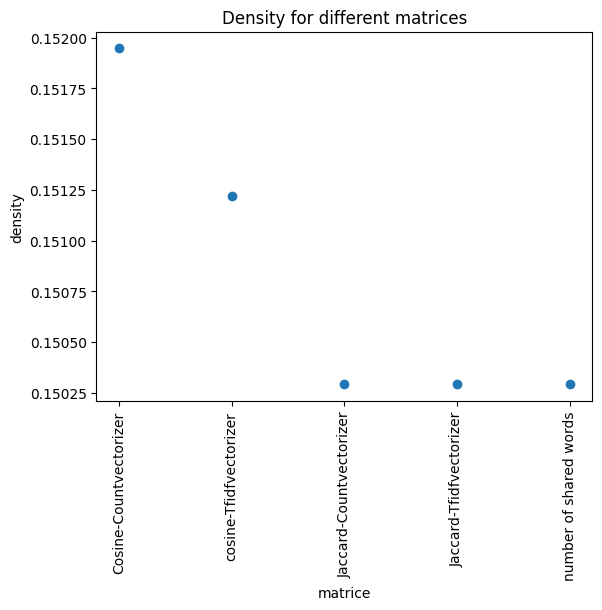

In [8]:
#finding the density for original marices

dens_list = []
for i in range(5):
  g = nx.from_numpy_array(mat_list[i])
  dens_list = dens_list + [nx.density(g)]


label_dict = {0: 'Cosine-Countvectorizer', 1: 'cosine-Tfidfvectorizer', 2: 'Jaccard-Countvectorizer', 3: 'Jaccard-Tfidfvectorizer', 4: 'number of shared words'}
x = np.arange(0,5,1)
plt.scatter(x, dens_list)
plt.xticks(range(len(label_dict)), list(label_dict.values()), rotation=90)
plt.xlabel('matrice')
plt.ylabel('density')
plt.title('Density for different matrices')

density 0 = 0.15025936401424497
density 1 = 0.15028455610392882
density 2 = 0.15028455610392882
density 3 = 0.15028455610392882
density 4 = 0.1502914266738426


Text(0.5, 1.0, 'Density for different binarized matrices')

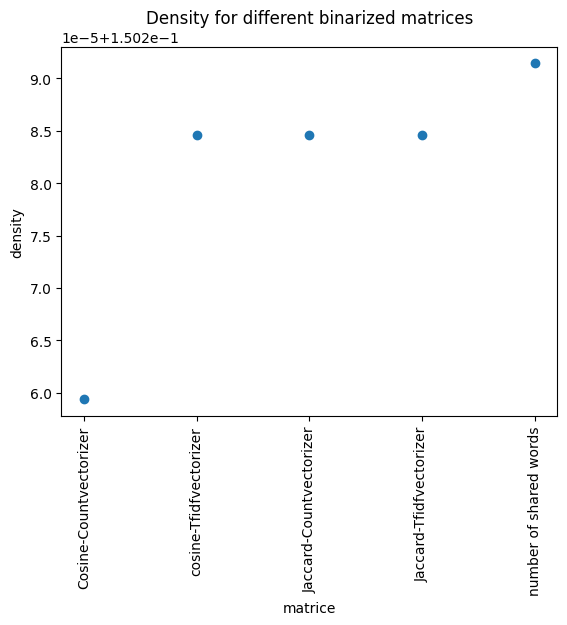

In [9]:
#setting treshold to binarizing networks all have same density after binarizing

import networkx as nx
bin_list = []
tr = [0.02, 0.005, 0.01, 0.01, 0.8]
low_dens_list = []

for i in range(5):
  g = nx.from_numpy_array(binarizing(mat_list[i],tr[i]))
  bin_list = bin_list + [binarizing(mat_list[i],tr[i])]
  low_dens_list = low_dens_list + [nx.density(g)]
  a = nx.number_of_nodes(g) * (nx.number_of_nodes(g)-1)//2
  b = nx.number_of_edges(g)
  print('density', i,'=', nx.density(g))


label_dict = {0: 'Cosine-Countvectorizer', 1: 'cosine-Tfidfvectorizer', 2: 'Jaccard-Countvectorizer', 3: 'Jaccard-Tfidfvectorizer', 4: 'number of shared words'}
x = np.arange(0,5,1)
plt.scatter(x, low_dens_list)
plt.xticks(range(len(label_dict)), list(label_dict.values()), rotation=90)
plt.xlabel('matrice')
plt.ylabel('density')
plt.title('Density for different binarized matrices')

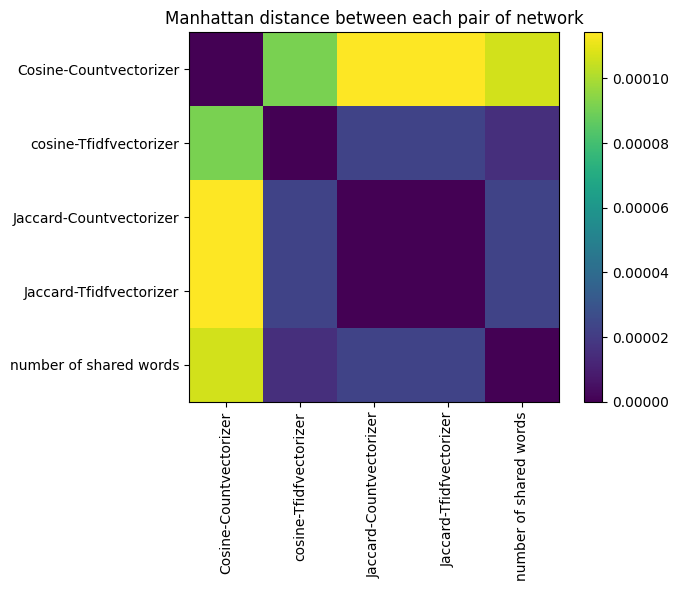

In [13]:
#finding Manhattan distance between each matrices

dis_mat = np.zeros((5,5))
for i in range(5):
  for j in range(5):
    q = (np.sum(bin_list[i])+np.sum(bin_list[j]))/2
    dis_mat[i][j] = np.linalg.norm(bin_list[i]-bin_list[j], ord=1)/q
    # print('Norm 1 distance', i, j, '=',dis_mat[i][j] )



label_dict = {0: 'Cosine-Countvectorizer', 1: 'cosine-Tfidfvectorizer', 2: 'Jaccard-Countvectorizer', 3: 'Jaccard-Tfidfvectorizer', 4: 'number of shared words'}
plt.imshow(dis_mat, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(label_dict)), list(label_dict.values()), rotation=90)
plt.yticks(range(len(label_dict)), list(label_dict.values()))
plt.title('Manhattan distance between each pair of network')
plt.show()